Colon adenocarcinoma

Colon benign tissue

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
#from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.xception import Xception
from keras.applications import *
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from PIL import Image
import random
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.decomposition import PCA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image_set= '/content/drive/MyDrive/PhDProject/colon_image_sets'

In [4]:
for i,d in enumerate([image_set]):
    filepaths=[]
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        classpath=os.path.join(d,klass)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries= pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    lung_df=pd.concat([Fseries, Lseries], axis=1)
df=pd.concat([lung_df], axis =0).reset_index(drop=True)# make a combined dataframe

print(df['labels'].value_counts())

colon_normal            5000
colon_adenocarcinoma    5000
Name: labels, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train_split=.7
test_split=.15
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), ' _test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  7000  _test_df length:  1499   valid_df length:  1501


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
height=224
width=224
channels=3
batch_size=32
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)
train_set=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_set=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
validate_set=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
#classes=list(train_gen.class_indices.keys())
#class_count=len(classes)

test batch size:  1   test steps:  1499
Found 7000 validated image filenames belonging to 2 classes.
Found 1499 validated image filenames belonging to 2 classes.
Found 1501 validated image filenames belonging to 2 classes.


In [8]:
IMAGE_SIZE = [224, 224]

In [9]:
# importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [10]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

Tensorflow version 2.12.0


tpu detection

In [11]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [ ]:
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Dropout,
    Input,
    Activation,
    concatenate,
)

In [12]:
bnmomemtum = 0.9


def fire_module(x, squeeze, expand):
    y = Conv2D(filters=squeeze, kernel_size=1, activation="relu", padding="same")(x)
    y = BatchNormalization(momentum=bnmomemtum)(y)
    y1 = Conv2D(filters=expand // 2, kernel_size=1, activation="relu", padding="same")(y)
    y1 = BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = Conv2D(filters=expand // 2, kernel_size=3, activation="relu", padding="same",dilation_rate=2)(y)
    y3 = BatchNormalization(momentum=bnmomemtum)(y3)
    return concatenate([y1, y3])


def SqueezeNet(input_shape, num_classes):
    input = Input(shape=input_shape)
    y = Conv2D(kernel_size=7, filters=96, strides=2, padding="same", activation="relu")(input)
    y = BatchNormalization(momentum=bnmomemtum)(y)
    y = MaxPooling2D(pool_size=3, strides=2)(y)
    y = fire_module(y, 16, 64)
    y = fire_module(y, 16, 64)
    y = fire_module(y, 32, 128)
    y = MaxPooling2D(pool_size=3, strides=2)(y)
    y = fire_module(y, 32, 128)
    y = fire_module(y, 48, 192)
    y = fire_module(y, 48, 192)
    y = fire_module(y, 64, 256)
    y = MaxPooling2D(pool_size=2)(y)
    y = fire_module(y, 64, 256)
    y = Conv2D(kernel_size=1, filters=1000, strides=1, padding="same", activation="relu")(y)
    y = GlobalAveragePooling2D()(y)
    y = Dense(num_classes, activation="softmax")(y)
    model = Model(input, y)
    return model

In [13]:
categories = {'benign', 'adenocarcinoma'}

In [14]:
model = SqueezeNet(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), num_classes=len(categories)
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

NameError: ignored

In [ ]:
# COMPILING THE MODEL

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
#executing the model
history = model.fit(train_set, validation_data = (validate_set), epochs = 10, verbose = 1)

Epoch 1/10
219/219 [==============================] - 854s 4s/step - loss: 0.1428 - accuracy: 0.9461 - val_loss: 0.3342 - val_accuracy: 0.9247
Epoch 2/10
219/219 [==============================] - 50s 228ms/step - loss: 0.0572 - accuracy: 0.9803 - val_loss: 0.1096 - val_accuracy: 0.9574
Epoch 3/10
219/219 [==============================] - 50s 226ms/step - loss: 0.0260 - accuracy: 0.9903 - val_loss: 0.0152 - val_accuracy: 0.9947
Epoch 4/10
219/219 [==============================] - 50s 228ms/step - loss: 0.0368 - accuracy: 0.9881 - val_loss: 0.1183 - val_accuracy: 0.9527
Epoch 5/10
219/219 [==============================] - 49s 222ms/step - loss: 0.0206 - accuracy: 0.9916 - val_loss: 0.0944 - val_accuracy: 0.9847
Epoch 6/10
219/219 [==============================] - 50s 227ms/step - loss: 0.0258 - accuracy: 0.9920 - val_loss: 0.2111 - val_accuracy: 0.9587
Epoch 7/10
219/219 [==============================] - 51s 232ms/step - loss: 0.0109 - accuracy: 0.9963 - val_loss: 0.3352 - val_accu

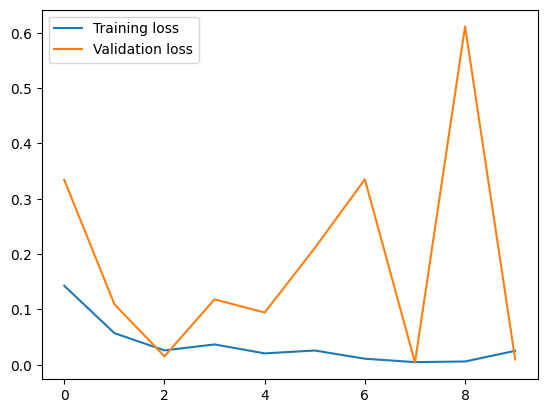

In [ ]:
# plotting the loss
plt.plot(history.history['loss'],label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
#plt.title('loss')
plt.legend()
plt.show()

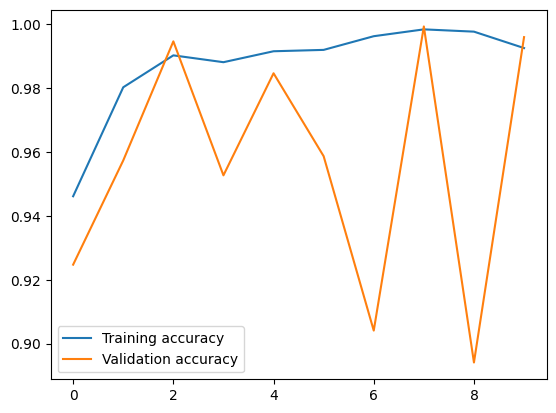

In [ ]:
# Both Validation and Training accuracy is shown here

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
#plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# CHECKING THE CONFUSION MATRIX

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred ,axis =1)


1499/1499 [==============================] - 149s 98ms/step


In [ ]:
print('Classification Report')
target_names = ['aca','n']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

         aca       1.00      0.99      1.00       770
           n       0.99      1.00      1.00       729

    accuracy                           1.00      1499
   macro avg       1.00      1.00      1.00      1499
weighted avg       1.00      1.00      1.00      1499



In [ ]:
loss, acc = model.evaluate_generator(test_set, len(test_set))

print ("\n\n================================\n\n")
print ("Loss: {}".format(loss))
print ("Accuracy: {0:.2f} %".format(acc * 100))
print ("\n\n================================\n\n")

test_set.reset()

<ipython-input-23-9a3d6d22a8aa>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_set, len(test_set))






Loss: 0.011663909070193768
Accuracy: 99.60 %






In [ ]:
result = model.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

1499/1499 [==============================] - 13s 9ms/step - loss: 0.0117 - accuracy: 0.9960
test_loss, test accuracy [0.011663909070193768, 0.9959973096847534]


In [ ]:
preds = model.predict(test_set,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

1499/1499 [==============================] - 12s 8ms/step


In [ ]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Y_pred = model.predict_generator(validation_generator, nb_validation_samples //
#batch_size+1)
y_pred = np.argmax(preds, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))

Confusion Matrix
[[765   5]
 [  1 728]]


In [ ]:
print('Classification Report')
target_names = [ 'Colon Benign','Colon Adenocarcinoma']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Classification Report
                      precision    recall  f1-score   support

        Colon Benign       1.00      0.99      1.00       770
Colon Adenocarcinoma       0.99      1.00      1.00       729

            accuracy                           1.00      1499
           macro avg       1.00      1.00      1.00      1499
        weighted avg       1.00      1.00      1.00      1499



In [ ]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

precision_score(test_set.classes, y_pred) , recall_score(test_set.classes, y_pred) ,  f1_score(test_set.classes, y_pred)

(0.9931787175989086, 0.9986282578875172, 0.9958960328317373)

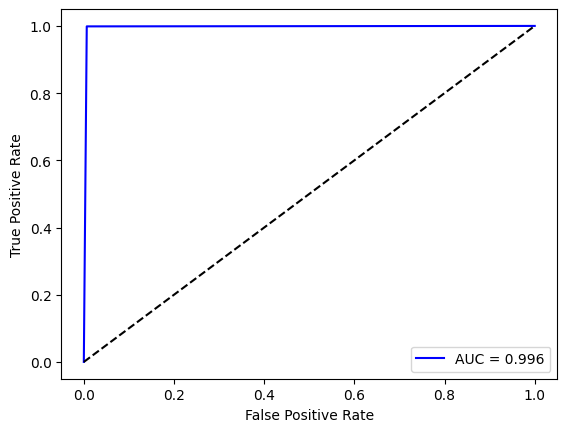

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(test_set.classes, y_pred)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
#plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.title('ROC curve')

plt.show()

<Axes: >

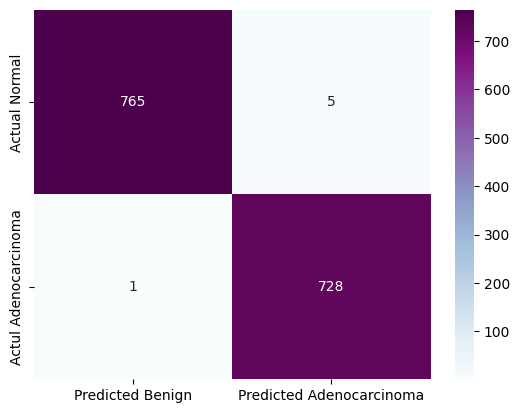

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix( y_true= test_set.classes, y_pred= y_pred, labels=[0, 1]), index=["Actual Normal", "Actul Adenocarcinoma"],columns=["Predicted Benign", "Predicted Adenocarcinoma"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d",cmap="BuPu")